# Analysis on ResMaskNet FER method using Padova Data

## Lib Import

In [46]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

In [47]:
# Directory
pred_dir = 'data/combined_results.csv'
clips_dir  = 'data/PEDFE_set_clips/'  
labels_dir = 'data/Supplemental_Material_T1.csv'

# load data to panda dataframe
labels = pd.read_csv(labels_dir)
predicted_data = pd.read_csv(pred_dir)

## Pandova Analysis

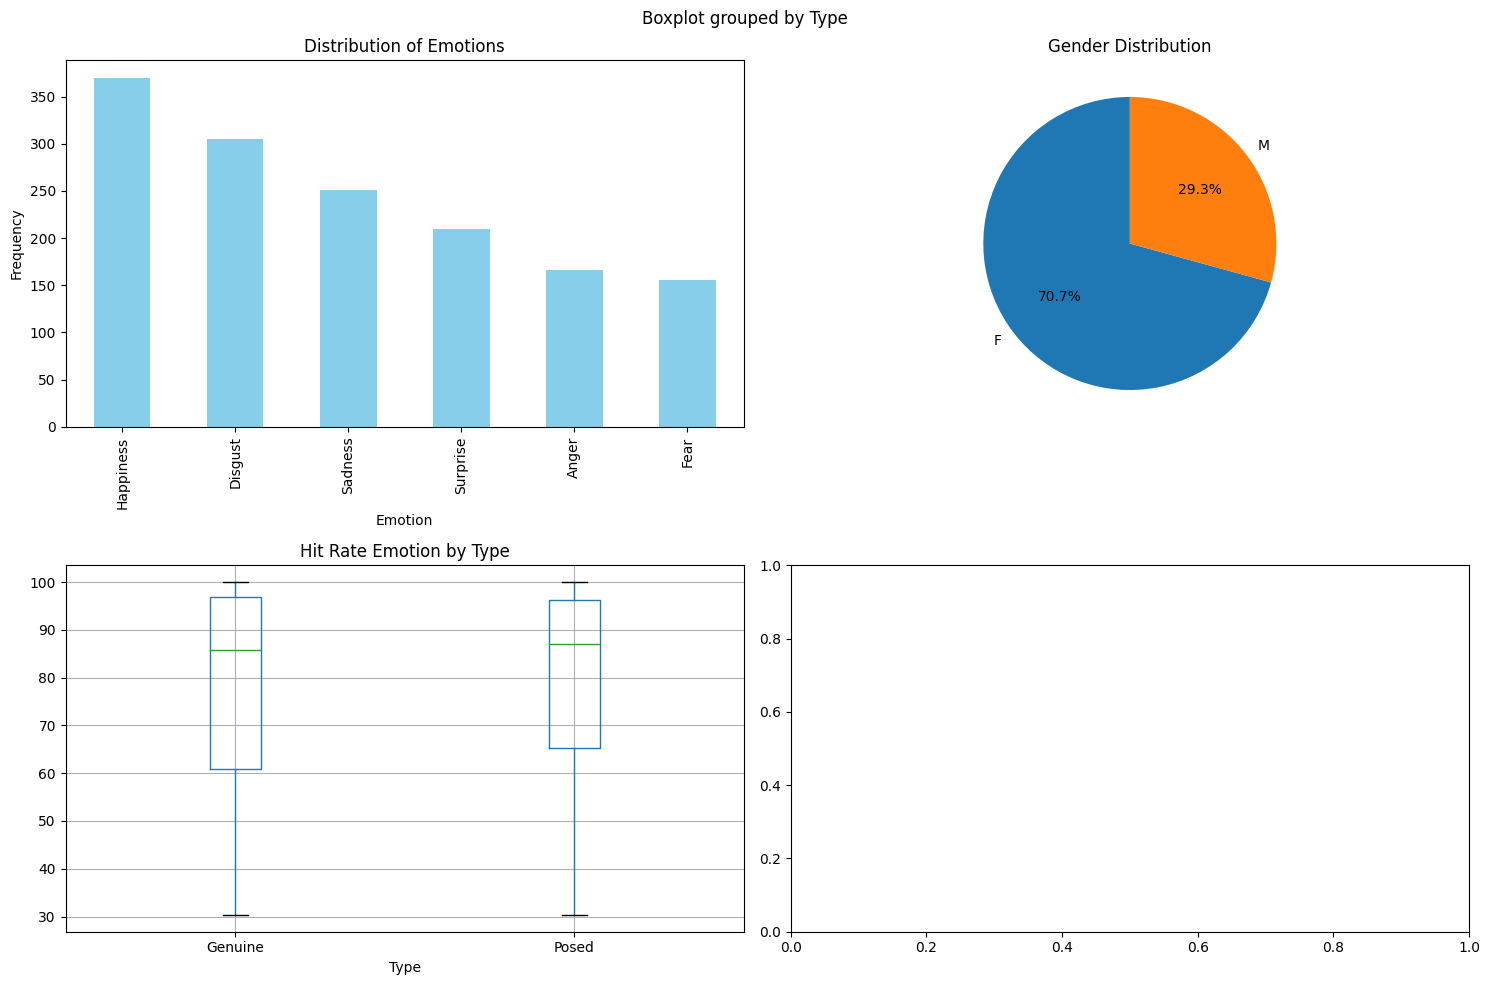

In [48]:
# fig with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Histogram of Emotions
labels['Emotion'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Emotions')
axes[0, 0].set_xlabel('Emotion')
axes[0, 0].set_ylabel('Frequency')

# Gender Distribution
labels['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution')
axes[0, 1].set_ylabel('')

# Hit Rate Emotion by Emotion Type
labels.boxplot(column='Hit rate Emotion (%)', by='Type', ax=axes[1, 0])
axes[1, 0].set_title('Hit Rate Emotion by Type')
axes[1, 0].set_xlabel('Type')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Data preprocessing

In [49]:
# emotion to lowercase for comparison
labels['Emotion'] = labels['Emotion'].str.lower()

# extract highest mean as predicted emotion
if 'predicted_emotion' not in predicted_data: 
    predicted_data['predicted_emotion'] = predicted_data.iloc[:, 1:].idxmax(axis=1).str.split('_').str[1]

# Merge actual and predicted data on 'PEDFE_code'
merged_data = pd.merge(labels, predicted_data, on='PEDFE_code')

# Create a column for binary prediction 
merged_data['pred'] = (merged_data['Emotion'] == merged_data['predicted_emotion']).astype(int)

# Select only the specified columns
selected_columns = [
    'PEDFE_code', 'Gender', 'Type', 'Hit rate Emotion (%)', 'Mean_Genuineness',
    'Mean_Intensity', 'mean_anger', 'mean_disgust', 'mean_fear', 'mean_happiness',
    'mean_sadness', 'mean_surprise', 'mean_neutral', 'Emotion', 'predicted_emotion', 'pred'
]
print("merged_data\n", merged_data[selected_columns].head(3))  # Print merged data with selected columns

merged_data
   PEDFE_code Gender     Type  Hit rate Emotion (%)  Mean_Genuineness  \
0     1_dg_1      F  Genuine                 78.79              2.12   
1     1_dg_2      F  Genuine                 54.55              3.00   
2     1_dg_3      F  Genuine                100.00              4.96   

   Mean_Intensity  mean_anger  mean_disgust  mean_fear  mean_happiness  \
0            2.94    0.018696      0.521609   0.003493        0.002931   
1            3.52    0.067074      0.277590   0.003294        0.000530   
2            5.92    0.033363      0.034911   0.049571        0.096554   

   mean_sadness  mean_surprise  mean_neutral  Emotion predicted_emotion  pred  
0      0.400101       0.000314      0.052858  disgust           disgust     1  
1      0.583805       0.000409      0.067298  disgust           sadness     0  
2      0.712607       0.032633      0.040361  disgust           sadness     0  


## Correlation_matrix

In [50]:
correlation_matrix = merged_data[['Hit rate Emotion (%)', 'Mean_Genuineness', 'Mean_Intensity']].corr()
print("Correlation Matrix\n",correlation_matrix)

report = classification_report(merged_data['Emotion'], merged_data['predicted_emotion'], labels=merged_data['Emotion'].unique())
print("\nReport\n",report)

Correlation Matrix
                       Hit rate Emotion (%)  Mean_Genuineness  Mean_Intensity
Hit rate Emotion (%)              1.000000          0.014555        0.436330
Mean_Genuineness                  0.014555          1.000000        0.184682
Mean_Intensity                    0.436330          0.184682        1.000000

Report
               precision    recall  f1-score   support

     disgust       0.69      0.32      0.44       303
   happiness       0.73      0.95      0.82       370
        fear       0.40      0.08      0.13       156
       anger       0.56      0.11      0.19       166
    surprise       0.63      0.36      0.46       210
     sadness       0.37      0.71      0.48       251

   micro avg       0.57      0.50      0.53      1456
   macro avg       0.56      0.42      0.42      1456
weighted avg       0.59      0.50      0.49      1456



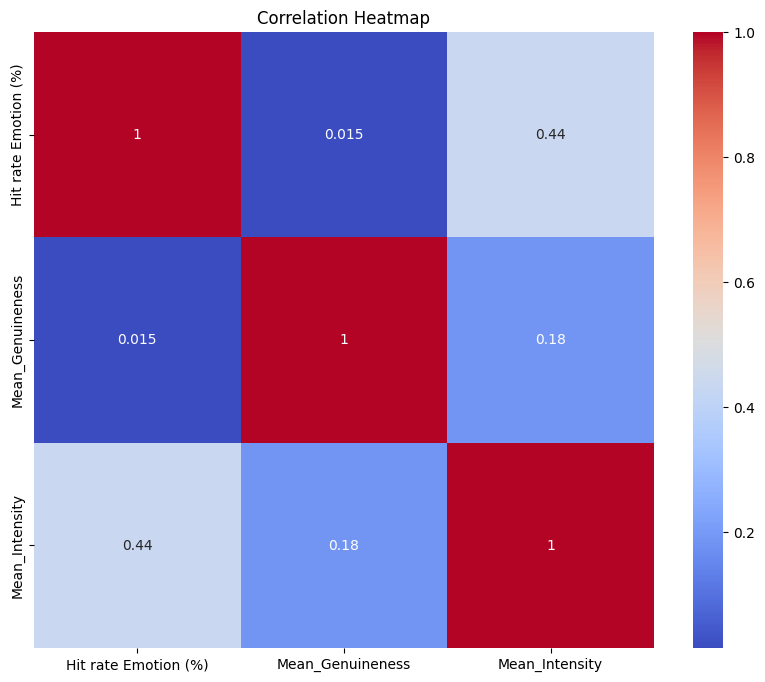

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## ANOVA (Type II)
- Dependent variable: Emotion Classifcation (1=correct, 0=incorrect)
- Independent variables: 'Mean_Intensity', 'Mean_Genuineness', and 'Hit rate Emotion (%)'

In [52]:
# Dependent variable = 'pred'
# Independent variables: 'Mean_Intensity', 'Mean_Genuineness', and 'Hit rate Emotion' as 
model_formula_full = 'pred ~ Mean_Intensity + Mean_Genuineness + Q("Hit rate Emotion (%)")'

# Fit the ANOVA model
model_full = ols(model_formula_full, data=merged_data).fit()

# Type II ANOVA
anova_results_full = sm.stats.anova_lm(model_full, typ=2)

# print ANOVA table
print(anova_results_full)

                               sum_sq      df           F        PR(>F)
Mean_Intensity               1.641121     1.0    7.691038  5.620558e-03
Mean_Genuineness             0.741638     1.0    3.475654  6.247977e-02
Q("Hit rate Emotion (%)")   49.492560     1.0  231.944666  1.055048e-48
Residual                   309.829058  1452.0         NaN           NaN


 - **Sum of squares**: 
   - amount of variance in the dependent variable explained by each factor
 - **Degrees of Freedom**: 
   - the number of independent values in a data set that are free to vary. 
   - 1 df means they are continuous variables.
 - **F-statistic**: 
   - the result of a ratio of two variances: the variance explained by the factor (between-group variance) divided by the unexplained variance. It helps determine if the means across different groups are significantly different.
   - A high F-value indicates that there is more variation between groups than within groups, suggesting that the factor has a significant effect on the dependent variable. 
   - *Hit rate Emotion* has a very high F-value, indicating a strong effect on the outcome variable.
 - **P-value**: 
   - the probability of obtaining a result at least as extreme as the one observed, assuming that the null hypothesis (of no effect) is true. Assess the significance of the results.
   - A low p-value (less than 0.05) suggests that the observed data are unlikely under the null hypothesis and thus provides evidence against the null hypothesis. 
   - The p-value for *Hit rate Emotion* is extremely low, suggesting strong evidence against the null hypothesis and indicating a significant effect on the dependent variable.

# ANOVA Analysis Results

| Source                  | Sum of Squares | Degrees of Freedom | F-statistic | P-value           |
|-------------------------|----------------|--------------------|-------------|-------------------|
| Mean_Intensity          | 1.641121       | 1.0                | 7.691038    | 0.0056            |
| Mean_Genuineness        | 0.741638       | 1.0                | 3.475654    | 0.0625            |
| Hit rate Emotion (%)    | 49.492560      | 1.0                | 231.944666  | < 1.0e-48         |
| Residual                | 309.829058     | 1452.0             | N/A         | N/A               |

- **Mean Intensity**: The F-statistic of 7.691 and a p-value of 0.0056 indicate that the mean intensity of emotional expressions has a statistically significant effect on the accuracy of emotion classification. The low p-value suggests that variations in intensity are likely to impact classification accuracy.

- **Mean Genuineness**: With an F-statistic of 3.476 and a p-value of 0.0625, the mean genuineness shows a borderline significant effect on classification accuracy. This suggests that while genuineness may influence classification accuracy, the evidence is weaker compared to mean intensity.

- **Hit rate Emotion (%)**: The hit rate has a very high F-statistic of 231.945 and a p-value of less than 1.0e-48, indicating an extremely strong effect on classification accuracy. This suggests that the hit rate of emotion recognition is a critical factor in determining the accuracy of the classification.

- **Residual**: Represents the variation not explained by the model.

## Cnnfusion Matrix

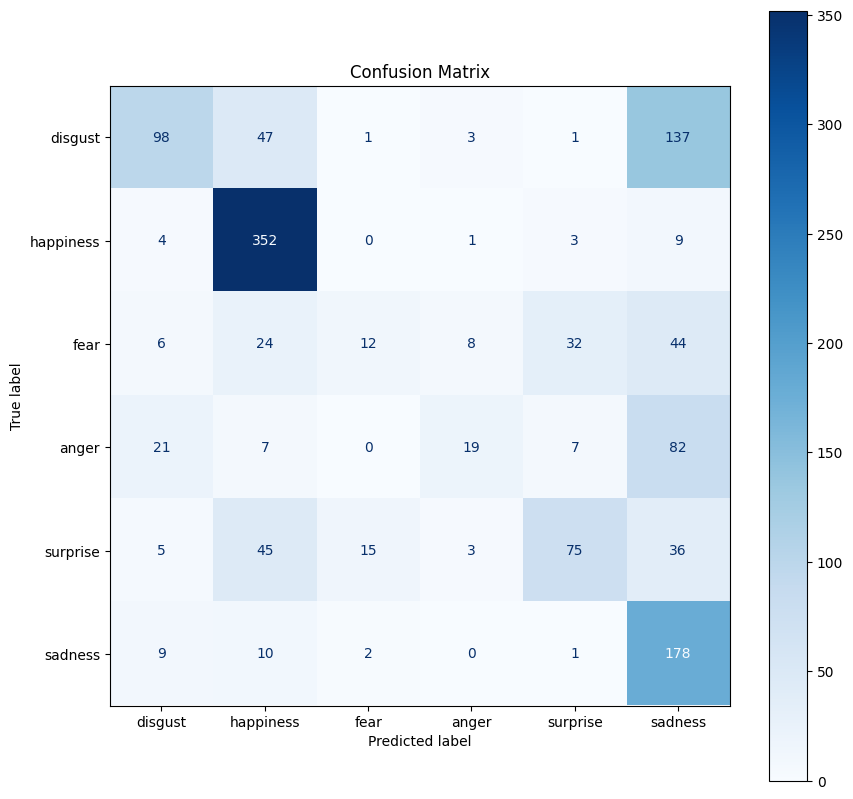

In [53]:
actual_emotions = merged_data['Emotion']
predicted_emotions = merged_data['predicted_emotion']

# Generate the confusion matrix
cm = confusion_matrix(actual_emotions, predicted_emotions, labels=actual_emotions.unique())

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # You can adjust the figure size as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actual_emotions.unique())
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()